In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/02 15:58:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import delta
from pyspark.sql.functions import concat,lit,substring
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.functions import when

23/12/02 15:59:08 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [10]:
# read data
yellow = spark.read.parquet("../data/landing/yellow_data/*")

In [11]:
# get the original data size
yellow.count()

39656098

Remove data with 0 and less than 0 passenger and trip distance

In [12]:
# get the number of data we are going to remove
(yellow.where(F.col('passenger_count') <= 0)).count()

763344

In [13]:
(yellow.where(F.col('trip_distance') <= 0)).count()

574059

In [14]:
# remove data with 0 passener and 0 trip distance
yellow = yellow.where((F.col('passenger_count') > 0) & (F.col('trip_distance') > 0))

According to the law of New York Transport, the maximum passenger of yellow taxi is 5, so we exclude trip that have at least 6 passengers.

In [15]:
# get the number of data we are going to remove
print((yellow.where(F.col('passenger_count') > 5)).count())
# remove data with more than 5 passengers
yellow = yellow.where((F.col('passenger_count')) <= 5)

457191


Check whether there are only data in 2022, and extract the year and date for each trip

In [16]:
# create a function to identify the pick up year and date, and store them into two attributes.
def year_date(file):
    file = file.withColumn("pickup_year",substring("tpep_pickup_datetime",1,4))
    file = file.withColumn("pickup_date",substring("tpep_pickup_datetime",6,5))
    return file

In [17]:
# identify the year and date for our data set
yellow = year_date(yellow)

In [18]:
# see whether there is only 2022 data
yellow.groupby('pickup_year').count()

pickup_year,count
2009,36
2022,36580858
2008,33
2003,7
2002,366
2023,5
2001,6
2021,23


In [19]:
# get the number of data we are going to remove
print((yellow.where(F.col('pickup_year') != 2022)).count())
# only keep data in 2022
yellow = yellow.where(F.col('pickup_year') == 2022)

476


Identify whether the trip is happened at holiday\
https://www.officeholidays.com/countries/usa/new-york/2022

In [20]:
# create a list of holiday dates
holiday = ['01-01','01-17','02-12','02-21','04-17','05-08','05-30','06-19','06-20',
           '07-04','09-05','10-10','11-08','11-11','11-24','12-25','12-26']

# create a boolean value to see whether the trip occurred at a holiday
yellow = yellow.withColumn("holiday", lit(yellow['pickup_date'].isin(holiday)))
yellow = yellow.withColumn('holiday',when(yellow.holiday == True, 1)\
    .otherwise(0))

Identify whether the trip is happened at the weekend

In [21]:
# create a boolean value to see whether the trip occurred at weekend
yellow = yellow.withColumn("weekend", dayofweek(col("tpep_pickup_datetime")).isin(['6','7']))
yellow = yellow.withColumn('weekend',when(yellow.weekend == True, 1)\
    .otherwise(0))

Given by the description of TLC, we  only have 2 values for vendorID, so we change it into boolean.

In [22]:
# change vendorid into boolean
yellow = yellow.withColumn('vendorid',when(yellow.vendorid == 1, 0)\
    .otherwise(1))

Since this project focus on tip amount, and only credit card payment has tip amount, so we only keep trip paid by credit card.

In [23]:
# get the number of data we are going to remove
print(yellow.where(F.col('payment_type') != 1).count())

# keep trip paid by credit card
yellow = yellow.where(F.col('payment_type') == 1)

# calculate the proportion of tip in total amount of fare amount
yellow = yellow.withColumn("tip_prop", lit((yellow.tip_amount/yellow.fare_amount)))

7724991


Identify the time slot\
1 for morning\
2 for afternoon\
3 for evening\
4 for midnight

In [24]:
# create a function to identify the time spot. The category is written above.
def time_slot(hour):
    return (when(hour.isin(['6','7','8','9','10','11']), 1).
    when(hour.isin(['12','13','14','15','16','17']),2).
    when(hour.isin(['18','19','20','21','22']),3).
    otherwise(4))

In [25]:
# identify the time slot for each trip
yellow = yellow.withColumn("time_slot", lit(time_slot(hour('tpep_pickup_datetime'))))

In [26]:
yellow.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+-----------+-------+-------+-------------------+---------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pickup_year|pickup_date|holiday|weekend|           tip_prop|time_slot|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+-----------+-------+-------+--------

In [27]:
# drop columns that we are no longer interested
yellow = yellow.drop("tpep_pickup_datetime","tpep_dropoff_datetime","payment_type")

In [28]:
yellow.count()

28855867

In [29]:
# remove data that have at least null attribute value
yellow = yellow.dropna("any")
print(yellow.count())

28855311


Detect outliers

In [30]:
# use summary to compare the mean, standatd deviance, minimum and maximum to detect outliers.
yellow.select('trip_distance','tip_prop','tip_amount','fare_amount','total_amount').describe().show()

23/12/02 16:08:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+--------------------+-----------------+------------------+------------------+
|summary|    trip_distance|            tip_prop|       tip_amount|       fare_amount|      total_amount|
+-------+-----------------+--------------------+-----------------+------------------+------------------+
|  count|         28855311|            28855311|         28855311|          28855311|          28855311|
|   mean|3.575562669208323| 0.26614249950104624|3.437386629101838|14.658658134025153|22.297837891799354|
| stddev|45.64512529362483|   6.368615125612078|3.223870712233825|13.229839759989726|17.258291872463527|
|    min|             0.01|-0.24400000000000002|           -98.01|             -93.3|            -174.3|
|    max|        164072.79|             20000.0|          1400.16|             870.0|           1447.96|
+-------+-----------------+--------------------+-----------------+------------------+------------------+



From research, the recommended tip amount should be 20% of the fare amount. Hence, we keep trip with tip proportion within 0 and 0.5.\
https://newyorkpass.com/en-us/blog/cab-etiquette-in-nyc#:~:text=How%20much%20should%20I%20tip,fee%20is%20the%20recommended%20amount.\
Also, the average distance of yellow taxi is 300 km, so we remove unrealistic trip distance.\
https://en.wikipedia.org/wiki/Taxis_of_New_York_City#:~:text=Taxicab%20vehicles%2C%20each%20of%20which,taxicab%20medallion%20licenses%20in%20existence.

In [31]:
# get the number of data we are going to remove
print((yellow.where((F.col('tip_prop') < 0) | (F.col('tip_prop') > 0.5) | 
              (F.col('trip_distance') > 500))).count())
# keep the data that satisfy the conditions written above.
yellow = yellow.where((F.col('tip_prop') >= 0) & (F.col('tip_prop') <= 0.5) & 
                      (F.col('trip_distance') <= 500))

475570


Given that the starting price of a trip is $2.5. Hence we remove all trip that has price less than $2.5

In [32]:
# get the number of data we are going to remove
print(yellow.where((F.col('tip_amount') < 0) & (F.col('fare_amount') < 2.5) & 
                   (F.col('total_amount') < 2.5)).count())
# keep data with positive revenue
yellow = yellow.where((F.col('tip_amount') >= 0) & (F.col('fare_amount') >= 2.5) & 
                      (F.col('total_amount') >= 2.5))

47


Adding weather data, assuming the temperature of new york city is same for every zone.\
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail\
data description linked below\
https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
# read our external data
weather = pd.read_csv("../data/raw/weather.csv")

Determine the strength of wind based on AWND (average wind speed meters per second)\
https://www.weather.gov/mfl/beaufort

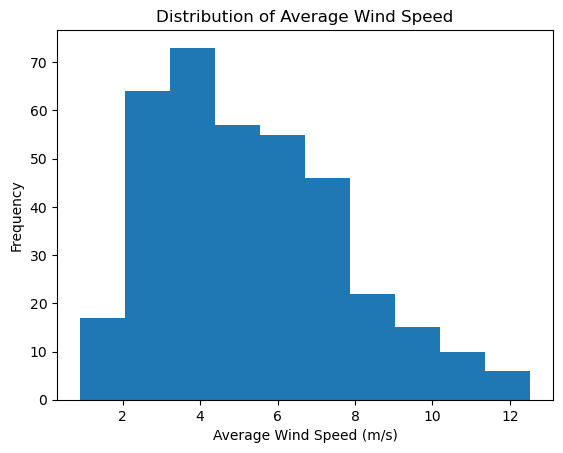

In [35]:
# define the wind strength based on the distribution of average wind speed
# draw a histogram to visualize the distribution of average wind speed
weather["AWND"].plot(kind="hist")
plt.xlabel('Average Wind Speed (m/s)')
plt.title('Distribution of Average Wind Speed')
plt.show()

Identify the level of wind speed\
level 1 for 0-2m/s\
level 2 for 2-4m/s\
level 3 for 4-6m/s\
level 4 for 6-8m/s\
level 5 for 8-15m/s


In [36]:
# categorize wind strength as mentioned above
weather.loc[weather["AWND"] < 2, 'wind_strength'] = '1'
weather.loc[(weather["AWND"] >= 2) & (weather["AWND"] < 4), 'wind_strength'] = '2'
weather.loc[(weather["AWND"] >= 4) & (weather["AWND"] < 6), 'wind_strength'] = '3'
weather.loc[(weather["AWND"] >= 6) & (weather["AWND"] < 8), 'wind_strength'] = '4'
weather.loc[weather["AWND"] >= 8, 'wind_strength'] = '5'

In [37]:
# let all nah value be 0
weather['SNOW'] = weather['SNOW'].apply(lambda x: '0' if x == 0 else '1')

In [38]:
# get the average temperature, since majority of TAVG is NULL
weather['TAVG'] = (weather['TMAX']+weather['TMIN'])/2

From the data description, 'WT01' represents light fog, and 'WT02' represents heavy fog. Since 'WT01' may include heavy fog, so we combine them as 'fog' (whether fog on that day)

In [39]:
# combine two features
weather.loc[(weather["WT01"] == 1) | (weather["WT02"] == 1), 'fog'] = '1'
weather['fog'] = weather['fog'].apply(lambda x: '1' if x == 1 else '0')

In [40]:
# rename the feature for easier understanding
weather = weather.rename(columns = {'WT03':'thunder'})
weather['thunder'] = weather['thunder'].apply(lambda x: '1' if x == 1 else '0')

In [41]:
weather = weather.rename(columns = {'WT08':'haze'})
weather['haze'] = weather['haze'].apply(lambda x: '1' if x == 1 else '0')

In [42]:
# change the column names to lower cases
weather.columns = weather.columns.str.lower()

In [43]:
# remove the year from 'date' column
weather['date'] = weather['date'].str[5:]

In [44]:
# keep the attributes that we need
weather_final = weather[['date','snow','tavg','fog','thunder','haze','wind_strength']]

In [45]:
# store the adjusted weather into csv file
weather_final.to_csv("../data/curated/weather.csv",index=False)

In [46]:
# convert weather from pandas dataframe to pyspark dataframe
weather = spark.createDataFrame(weather_final)

# add weather into our taxi data set
yellow = yellow.join(weather,weather['date'] == yellow['pickup_date'],how='left')

In [47]:
# drop the feature that we are no longer interested
yellow = yellow.drop('pickup_year','pickup_date')

In [48]:
from pyspark.sql.functions import sum

In [54]:
# get the amount of trips in extreme weather
yellow.select(sum(yellow.snow),sum(yellow.fog),sum(yellow.thunder),sum(yellow.haze)).show()

+---------+--------+------------+---------+
|sum(snow)|sum(fog)|sum(thunder)|sum(haze)|
+---------+--------+------------+---------+
| 491718.0|     0.0|   2014925.0|4580087.0|
+---------+--------+------------+---------+



In [55]:
# Since there is no trip in fog, we delete fog as a feature.
yellow = yellow.drop('fog')

In [56]:
# save data into curated file
yellow.write.parquet("../data/curated/yellow.parquet")